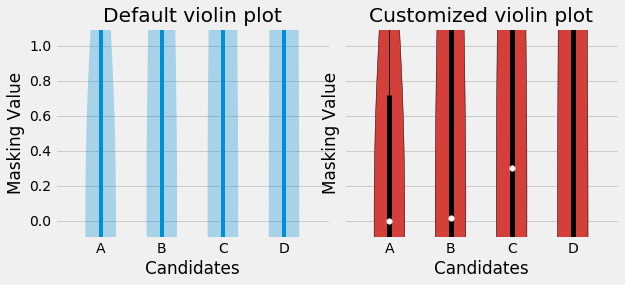

In [1]:
import matplotlib.pyplot as plt
plt.style.use('science')
import numpy as np


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Candidates')
    ax.set_ylabel("Masking Value")


# create test data
np.random.seed(19680801)
data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.set_title('Default violin plot')
ax1.set_ylabel('Observed values')
ax1.violinplot(data)

ax2.set_title('Customized violin plot')
parts = ax2.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['A', 'B', 'C', 'D']
for ax in [ax1, ax2]:
    set_axis_style(ax, labels)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

In [2]:
import pandas as pd
import os

In [3]:
def plot_violin(data_df, title, ground_truth, fname=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax.grid(False)

    ax.set_title(title)
    parts = ax.violinplot(
            data_df.to_numpy(), showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    quartile1, medians, quartile3 = np.percentile(data_df, [25, 50, 75], axis=0)

    mean = np.mean(data_df, axis=0)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip([np.sort(data_df[var]) for var in data_df], quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, mean, marker='x', color='orange', edgecolors="black", s=30, zorder=3, label="Mean")
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3, label="Median")
    ax.scatter(inds, ground_truth, marker='o', color='green', s=30, zorder=3, label="Ground Truth")
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=True)
    # set style for the axes
    labels = [f"${var.split('_')[0]}_" + "{" + f"{var.split('_')[1]}" + "}$" for var in data_df.columns]
    
    set_axis_style(ax, labels)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    if fname is not None:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        plt.savefig(f"plots/{fname}.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [4]:
gt = {
    "min": [1],
    "min2": [0],
    "basic": [1, 1, 0],
    "disc": [1, 1, 0],
    "exp": [1, 0, 1, 0],
    "med": [1, 0, 0, 1, 0, 0],
    "large": [1, 0, 0, 1, 0, 0, 0, 0, 0],
    "massive": [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
}
actual_names = {
    
    "min": "Minimal",
    "min2": "Minimal (no parents)",
    "basic": "Basic Gaussians",
    "disc": "Basic Discrete",
    "exp": "Exponentials",
    "med": "Medium Size Gaussians",
    "large": "Large Size Gaussians",
    "massive": "Massive Size"
}

In [5]:
dfs_single = dict()
dfs_multi = dict()
for filename in os.listdir("results"):
    print(filename)
    if "single" in filename:
        dfs_single[filename.split(".")[0]] = pd.read_csv(f"results/{filename}", index_col=None)
    if "multi" in filename:
        dfs_multi[filename.split(".")[0]] = pd.read_csv(f"results/{filename}", index_col=None)

In [6]:
for name, df in dfs_single.items():
    name = name.split('_')[-1]
    print(name)
    plot_violin(df, f"Single Model Results for {actual_names[name]}", gt[name], fname=f"single_{name}")
for name, df in dfs_multi.items():
    name = name.split('_')[-1]
    print(name)
    plot_violin(df, f"Multi Model Results for {actual_names[name]}", gt[name], fname=f"multi_{name}")

In [7]:
import seaborn as sns

/home/michael/anaconda3/envs/causalpy/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
dfs_collapsed = []
for setting in dfs_single:
    print(setting)
    temp = []
    for var in dfs_single[setting]:
        print(var)
        l = len(dfs_single[setting])
        temp.append(pd.DataFrame.from_dict({"Value": dfs_single[setting][var], "Experiment": [setting]*l, "Variable": [var]*l, "Model": ["Single"]*l}, orient="columns"))
    dfs_collapsed.append(pd.concat(temp))
    
for setting in dfs_multi:
    print(setting)
    temp = []
    for var in dfs_multi[setting]:
        print(var)
        l = len(dfs_multi[setting])
        temp.append(pd.DataFrame.from_dict({"Value": dfs_multi[setting][var], "Experiment": [setting]*l,"Variable": [var]*l, "Model": ["Multi"]*l}, orient="columns"))
    dfs_collapsed.append(pd.concat(temp))
dfs_collapsed = pd.concat(dfs_collapsed).reset_index(drop=True)
        

ValueError: No objects to concatenate

In [ ]:
dfs_collapsed

In [9]:
def plot_violin(data_df, title, gt, fname=None):
    grouped = data_df.groupby(by="Experiment")

    ax = sns.violinplot(x="Variable", y="Value", hue="Model",
                    data=data_df, palette="muted", split=True)
    ax.grid(False)

    plt.show()

SyntaxError: invalid syntax (<ipython-input-9-1e042aa817f8>, line 3)

AttributeError: 'list' object has no attribute 'to_numpy'

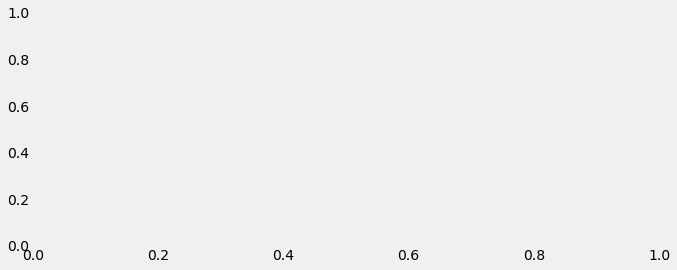

In [10]:
plot_violin(dfs_collapsed, "", [2])

In [ ]:
grouped = dfs_collapsed.groupby(by="Experiment")
for g, v in grouped:
    print(g)